<a href="https://colab.research.google.com/github/Cheekibreaki/ECE1508_ML_repo/blob/main/simple_diffusion_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
!unzip -q "/content/drive/MyDrive/ECE1508 - GenAI/dataset.zip" -d /content/dataset

replace /content/dataset/abstract_monochrome_patterned_outerwear_coat.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [101]:
!rm -rf /content/dataset/__MACOSX


# Intro

techniques used:

* forward diffusion: xₜ = √(ᾱₜ) * x₀ + √(1 - ᾱₜ) * ε

* random timestep sampling: Each training sample uses a random timestep t. Helps the model learn how to denoise at every stage.

* Timestep embedding: using sin/cos positional encoding.

* denoiser using simple CNN.

* Condition method: joint injection of time + text

Note that cross-attention, ResNet, classifier-free guidance, latent space modeling... are NOT used in this simple demo.

LLMs are not used, currently TextEmbed is a simple embedding layer that takes in class labels (0-9) to 32-dim vectors. These vectors are learned from scratch.

The CNN learns to denoise directly from the noisy image.
Conditioning is injected as a bias or feature addition.
No need for ResNet, don’t learn residuals

In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer, BertConfig
import os
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# BERT

In [113]:
# Dataset Class
class FashionCaptionDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x * 2. - 1.) # map to [-1,1] for centered training
        ])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        # Extract caption from filename
        caption = self.image_files[idx].replace('.png', '')
        caption = caption.replace('_', ' ').replace('.', ' ')
        caption = ' '.join(caption.split())  # Clean extra spaces

        return self.transform(image), caption

class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.proj = nn.Linear(768, 128)  # Project to smaller dimension

        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, captions):
        inputs = self.tokenizer(
            captions,
            padding=True,
            truncation=True,
            max_length=32,
            return_tensors="pt"
        ).to(device)

        outputs = self.bert(**inputs)
        pooled = outputs.pooler_output  # Use [CLS] token representation, it is the embedding from the final hidden layer
        return self.proj(pooled)

# Timestep Embedding

In [114]:
#convert a scalar timestep t into a vector of length dim
def get_timestep_embedding(t, dim):
    half_dim = dim // 2
    freqs = torch.exp(-torch.log(torch.tensor(10000.0)) * torch.arange(half_dim, device=t.device) / half_dim)
    args = t[:, None].float() * freqs[None]
    return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)


# Denoising Network

In [115]:
# small CNN, takes in noised image and outputs predicted noise

class DenoiseNet(nn.Module):
    def __init__(self, cond_dim=128, time_dim=32):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 1, 1)

        self.fc_cond = nn.Linear(cond_dim + time_dim, 32)

    def forward(self, x_t, t_embed, text_embed):
        cond = torch.cat([t_embed, text_embed], dim=1)  # shape: [B, 64]
        cond = self.fc_cond(cond).unsqueeze(-1).unsqueeze(-1)  # shape: [B, 32, 1, 1]
        h = F.relu(self.conv1(x_t) + cond)
        h = F.relu(self.conv2(h))
        return self.out(h)


# FashionMNIST as an example

In [128]:
ds = FashionCaptionDataset('/content/dataset')
test_size = int(0.2 * len(ds))
train_size = len(ds) - test_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)


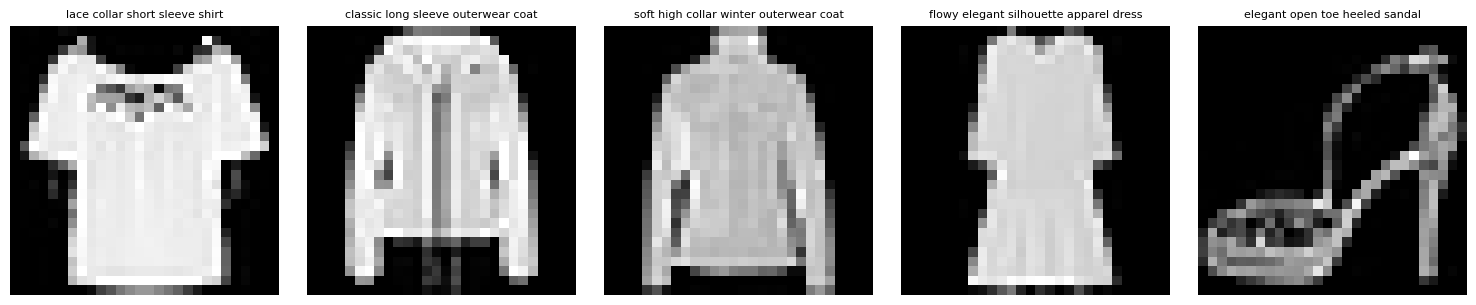


Caption 1: lace collar short sleeve shirt
Embedding shape: (128,)
Embedding values: [-0.85387295  0.2284035   0.25185612 -0.30280113 -0.04686115  0.37955752
  0.4587083   0.05572064  0.09056785  0.7025132  -0.26055074 -0.69472265
 -0.35910738 -0.02549444 -0.21078472  0.1983789   0.1978149   0.8285966
 -0.03470561  0.04712961  0.7444364  -0.35286117 -0.2731941  -0.35593885
 -0.09491054  0.32766375  0.54277694 -0.13716704 -0.14584754 -0.0785814
 -0.6404261  -0.4666136   0.05892618  0.18528256  0.3203143  -0.5153174
  0.03049695  0.00879768 -0.23904407 -0.61106604  0.78773206  0.80756825
 -0.5353769   0.34002846  0.14505905 -0.28487936  0.09983464 -0.18374975
 -0.06999248  0.20516813  0.5017194  -0.07233721 -0.75636595  0.18237726
 -0.562758   -0.7370337  -0.64894307  0.25827077  0.94575256 -0.8703008
 -0.32395676 -0.10442835  0.6596649  -0.4012158   0.01522325  0.3954149
 -0.17607765  0.93766963  0.18107963  0.21241497  0.22865261  0.30829272
 -0.06391926 -0.10939024  0.18765621  0.3061

In [134]:
# Get one batch
x_batch, y_batch = next(iter(train_loader))  # x: [B, 1, 28, 28], y: list of captions
x_batch = x_batch[:5]  # select first 5 samples
y_batch = y_batch[:5]  # corresponding captions

# Send to device and encode
x_batch = x_batch.to(device)
text_encoder = TextEncoder().to(device)
with torch.no_grad():
    text_embeddings = text_encoder(y_batch).cpu().numpy()  # shape: [5, 128]

# Plot images and print embeddings
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow((x_batch[i].cpu().squeeze() + 1) / 2, cmap='gray')  # inverse normalize
    axs[i].axis('off')
    axs[i].set_title(f"{y_batch[i]}", fontsize=8)

plt.tight_layout()
plt.show()

# Show text embedding summaries
for i in range(5):
    print(f"\nCaption {i+1}: {y_batch[i]}")
    print(f"Embedding shape: {text_embeddings[i].shape}")
    print(f"Embedding values: {text_embeddings[i][:]}")


# Training

In [135]:
# diffusion conf setup
T = 1000  # total diffusion steps
beta = torch.linspace(1e-4, 0.02, T).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)  # cumulative product

model = DenoiseNet().to(device)
#text_encoder = TextEncoder().to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(text_encoder.parameters()), lr=1e-3)

for epoch in range(200):
    for x, y in tqdm(train_loader):
        x = x.to(device)  # shape: [B, 1, 28, 28]

        t = torch.randint(0, T, (x.size(0),), device=device)  # random timestep per sample
        alpha_t = alpha_bar[t][:, None, None, None]  # shape: [B, 1, 1, 1]
        # print(alpha_t)
        noise = torch.randn_like(x)
        x_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise

        t_embed = get_timestep_embedding(t, 32)
        text_embed = text_encoder(y)

        pred_noise = model(x_t, t_embed, text_embed)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


100%|██████████| 2/2 [00:00<00:00, 18.35it/s]


Epoch 1, Loss: 0.8811


100%|██████████| 2/2 [00:00<00:00, 18.48it/s]


Epoch 2, Loss: 0.6711


100%|██████████| 2/2 [00:00<00:00, 21.47it/s]


Epoch 3, Loss: 0.4911


100%|██████████| 2/2 [00:00<00:00, 22.86it/s]


Epoch 4, Loss: 0.4204


100%|██████████| 2/2 [00:00<00:00, 23.34it/s]


Epoch 5, Loss: 0.3096


100%|██████████| 2/2 [00:00<00:00, 24.46it/s]


Epoch 6, Loss: 0.2074


100%|██████████| 2/2 [00:00<00:00, 23.54it/s]


Epoch 7, Loss: 0.2986


100%|██████████| 2/2 [00:00<00:00, 24.77it/s]


Epoch 8, Loss: 0.2893


100%|██████████| 2/2 [00:00<00:00, 23.98it/s]


Epoch 9, Loss: 0.3076


100%|██████████| 2/2 [00:00<00:00, 24.02it/s]


Epoch 10, Loss: 0.2571


100%|██████████| 2/2 [00:00<00:00, 20.66it/s]


Epoch 11, Loss: 0.1966


100%|██████████| 2/2 [00:00<00:00, 24.90it/s]


Epoch 12, Loss: 0.2729


100%|██████████| 2/2 [00:00<00:00, 24.80it/s]


Epoch 13, Loss: 0.2687


100%|██████████| 2/2 [00:00<00:00, 23.93it/s]


Epoch 14, Loss: 0.2385


100%|██████████| 2/2 [00:00<00:00, 22.79it/s]


Epoch 15, Loss: 0.1943


100%|██████████| 2/2 [00:00<00:00, 23.73it/s]


Epoch 16, Loss: 0.1465


100%|██████████| 2/2 [00:00<00:00, 23.60it/s]


Epoch 17, Loss: 0.0736


100%|██████████| 2/2 [00:00<00:00, 24.26it/s]


Epoch 18, Loss: 0.2761


100%|██████████| 2/2 [00:00<00:00, 23.23it/s]


Epoch 19, Loss: 0.3759


100%|██████████| 2/2 [00:00<00:00, 23.59it/s]


Epoch 20, Loss: 0.2362


100%|██████████| 2/2 [00:00<00:00, 24.18it/s]


Epoch 21, Loss: 0.1131


100%|██████████| 2/2 [00:00<00:00, 24.20it/s]


Epoch 22, Loss: 0.2110


100%|██████████| 2/2 [00:00<00:00, 24.00it/s]


Epoch 23, Loss: 0.2705


100%|██████████| 2/2 [00:00<00:00, 23.97it/s]


Epoch 24, Loss: 0.1282


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 25, Loss: 0.1488


100%|██████████| 2/2 [00:00<00:00, 22.98it/s]


Epoch 26, Loss: 0.2070


100%|██████████| 2/2 [00:00<00:00, 23.96it/s]


Epoch 27, Loss: 0.0768


100%|██████████| 2/2 [00:00<00:00, 23.63it/s]


Epoch 28, Loss: 0.1868


100%|██████████| 2/2 [00:00<00:00, 24.13it/s]


Epoch 29, Loss: 0.2709


100%|██████████| 2/2 [00:00<00:00, 21.96it/s]


Epoch 30, Loss: 0.0909


100%|██████████| 2/2 [00:00<00:00, 24.25it/s]


Epoch 31, Loss: 0.1750


100%|██████████| 2/2 [00:00<00:00, 24.61it/s]


Epoch 32, Loss: 0.1557


100%|██████████| 2/2 [00:00<00:00, 24.37it/s]


Epoch 33, Loss: 0.2500


100%|██████████| 2/2 [00:00<00:00, 25.12it/s]


Epoch 34, Loss: 0.2140


100%|██████████| 2/2 [00:00<00:00, 24.57it/s]


Epoch 35, Loss: 0.2087


100%|██████████| 2/2 [00:00<00:00, 24.78it/s]


Epoch 36, Loss: 0.2682


100%|██████████| 2/2 [00:00<00:00, 24.94it/s]


Epoch 37, Loss: 0.2582


100%|██████████| 2/2 [00:00<00:00, 26.26it/s]


Epoch 38, Loss: 0.1574


100%|██████████| 2/2 [00:00<00:00, 24.84it/s]


Epoch 39, Loss: 0.1345


100%|██████████| 2/2 [00:00<00:00, 24.32it/s]


Epoch 40, Loss: 0.2365


100%|██████████| 2/2 [00:00<00:00, 25.39it/s]


Epoch 41, Loss: 0.1212


100%|██████████| 2/2 [00:00<00:00, 25.29it/s]


Epoch 42, Loss: 0.3954


100%|██████████| 2/2 [00:00<00:00, 25.08it/s]


Epoch 43, Loss: 0.1031


100%|██████████| 2/2 [00:00<00:00, 23.77it/s]


Epoch 44, Loss: 0.0827


100%|██████████| 2/2 [00:00<00:00, 25.07it/s]


Epoch 45, Loss: 0.1370


100%|██████████| 2/2 [00:00<00:00, 25.52it/s]


Epoch 46, Loss: 0.1201


100%|██████████| 2/2 [00:00<00:00, 25.77it/s]


Epoch 47, Loss: 0.2499


100%|██████████| 2/2 [00:00<00:00, 25.05it/s]


Epoch 48, Loss: 0.0785


100%|██████████| 2/2 [00:00<00:00, 25.15it/s]


Epoch 49, Loss: 0.2237


100%|██████████| 2/2 [00:00<00:00, 24.80it/s]


Epoch 50, Loss: 0.2010


100%|██████████| 2/2 [00:00<00:00, 25.85it/s]


Epoch 51, Loss: 0.2736


100%|██████████| 2/2 [00:00<00:00, 26.04it/s]


Epoch 52, Loss: 0.1411


100%|██████████| 2/2 [00:00<00:00, 24.88it/s]


Epoch 53, Loss: 0.1179


100%|██████████| 2/2 [00:00<00:00, 24.21it/s]


Epoch 54, Loss: 0.2137


100%|██████████| 2/2 [00:00<00:00, 24.36it/s]


Epoch 55, Loss: 0.1997


100%|██████████| 2/2 [00:00<00:00, 24.17it/s]


Epoch 56, Loss: 0.1192


100%|██████████| 2/2 [00:00<00:00, 25.15it/s]


Epoch 57, Loss: 0.1273


100%|██████████| 2/2 [00:00<00:00, 25.38it/s]


Epoch 58, Loss: 0.1983


100%|██████████| 2/2 [00:00<00:00, 24.04it/s]


Epoch 59, Loss: 0.1653


100%|██████████| 2/2 [00:00<00:00, 23.25it/s]


Epoch 60, Loss: 0.2230


100%|██████████| 2/2 [00:00<00:00, 25.25it/s]


Epoch 61, Loss: 0.2945


100%|██████████| 2/2 [00:00<00:00, 24.78it/s]


Epoch 62, Loss: 0.1492


100%|██████████| 2/2 [00:00<00:00, 25.26it/s]


Epoch 63, Loss: 0.2005


100%|██████████| 2/2 [00:00<00:00, 25.30it/s]


Epoch 64, Loss: 0.1723


100%|██████████| 2/2 [00:00<00:00, 24.97it/s]


Epoch 65, Loss: 0.0603


100%|██████████| 2/2 [00:00<00:00, 24.51it/s]


Epoch 66, Loss: 0.2975


100%|██████████| 2/2 [00:00<00:00, 25.03it/s]


Epoch 67, Loss: 0.1678


100%|██████████| 2/2 [00:00<00:00, 25.22it/s]


Epoch 68, Loss: 0.2214


100%|██████████| 2/2 [00:00<00:00, 25.42it/s]


Epoch 69, Loss: 0.1311


100%|██████████| 2/2 [00:00<00:00, 24.96it/s]


Epoch 70, Loss: 0.1568


100%|██████████| 2/2 [00:00<00:00, 24.17it/s]


Epoch 71, Loss: 0.1590


100%|██████████| 2/2 [00:00<00:00, 24.29it/s]


Epoch 72, Loss: 0.1804


100%|██████████| 2/2 [00:00<00:00, 25.13it/s]


Epoch 73, Loss: 0.1566


100%|██████████| 2/2 [00:00<00:00, 25.46it/s]


Epoch 74, Loss: 0.2083


100%|██████████| 2/2 [00:00<00:00, 25.89it/s]


Epoch 75, Loss: 0.0807


100%|██████████| 2/2 [00:00<00:00, 25.18it/s]


Epoch 76, Loss: 0.1037


100%|██████████| 2/2 [00:00<00:00, 25.38it/s]


Epoch 77, Loss: 0.1669


100%|██████████| 2/2 [00:00<00:00, 25.44it/s]


Epoch 78, Loss: 0.1566


100%|██████████| 2/2 [00:00<00:00, 25.08it/s]


Epoch 79, Loss: 0.2255


100%|██████████| 2/2 [00:00<00:00, 25.05it/s]


Epoch 80, Loss: 0.0395


100%|██████████| 2/2 [00:00<00:00, 25.98it/s]


Epoch 81, Loss: 0.1412


100%|██████████| 2/2 [00:00<00:00, 26.00it/s]


Epoch 82, Loss: 0.2309


100%|██████████| 2/2 [00:00<00:00, 26.17it/s]


Epoch 83, Loss: 0.2260


100%|██████████| 2/2 [00:00<00:00, 25.26it/s]


Epoch 84, Loss: 0.0852


100%|██████████| 2/2 [00:00<00:00, 25.30it/s]


Epoch 85, Loss: 0.3466


100%|██████████| 2/2 [00:00<00:00, 25.17it/s]


Epoch 86, Loss: 0.0517


100%|██████████| 2/2 [00:00<00:00, 24.33it/s]


Epoch 87, Loss: 0.1546


100%|██████████| 2/2 [00:00<00:00, 24.73it/s]


Epoch 88, Loss: 0.2114


100%|██████████| 2/2 [00:00<00:00, 24.47it/s]


Epoch 89, Loss: 0.1876


100%|██████████| 2/2 [00:00<00:00, 25.41it/s]


Epoch 90, Loss: 0.1276


100%|██████████| 2/2 [00:00<00:00, 24.60it/s]


Epoch 91, Loss: 0.1242


100%|██████████| 2/2 [00:00<00:00, 25.01it/s]


Epoch 92, Loss: 0.0802


100%|██████████| 2/2 [00:00<00:00, 25.09it/s]


Epoch 93, Loss: 0.1463


100%|██████████| 2/2 [00:00<00:00, 25.34it/s]


Epoch 94, Loss: 0.0859


100%|██████████| 2/2 [00:00<00:00, 25.01it/s]


Epoch 95, Loss: 0.2677


100%|██████████| 2/2 [00:00<00:00, 24.49it/s]


Epoch 96, Loss: 0.1907


100%|██████████| 2/2 [00:00<00:00, 24.36it/s]


Epoch 97, Loss: 0.0881


100%|██████████| 2/2 [00:00<00:00, 24.72it/s]


Epoch 98, Loss: 0.1036


100%|██████████| 2/2 [00:00<00:00, 25.42it/s]


Epoch 99, Loss: 0.0883


100%|██████████| 2/2 [00:00<00:00, 25.73it/s]


Epoch 100, Loss: 0.0871


100%|██████████| 2/2 [00:00<00:00, 25.15it/s]


Epoch 101, Loss: 0.3878


100%|██████████| 2/2 [00:00<00:00, 25.35it/s]


Epoch 102, Loss: 0.0844


100%|██████████| 2/2 [00:00<00:00, 25.24it/s]


Epoch 103, Loss: 0.1457


100%|██████████| 2/2 [00:00<00:00, 25.06it/s]


Epoch 104, Loss: 0.1916


100%|██████████| 2/2 [00:00<00:00, 23.75it/s]


Epoch 105, Loss: 0.0877


100%|██████████| 2/2 [00:00<00:00, 24.53it/s]


Epoch 106, Loss: 0.0529


100%|██████████| 2/2 [00:00<00:00, 25.88it/s]


Epoch 107, Loss: 0.1130


100%|██████████| 2/2 [00:00<00:00, 25.72it/s]


Epoch 108, Loss: 0.0934


100%|██████████| 2/2 [00:00<00:00, 24.38it/s]


Epoch 109, Loss: 0.1601


100%|██████████| 2/2 [00:00<00:00, 24.71it/s]


Epoch 110, Loss: 0.1716


100%|██████████| 2/2 [00:00<00:00, 25.09it/s]


Epoch 111, Loss: 0.2632


100%|██████████| 2/2 [00:00<00:00, 26.19it/s]


Epoch 112, Loss: 0.0529


100%|██████████| 2/2 [00:00<00:00, 25.26it/s]


Epoch 113, Loss: 0.1470


100%|██████████| 2/2 [00:00<00:00, 24.56it/s]


Epoch 114, Loss: 0.2298


100%|██████████| 2/2 [00:00<00:00, 24.88it/s]


Epoch 115, Loss: 0.0963


100%|██████████| 2/2 [00:00<00:00, 25.08it/s]


Epoch 116, Loss: 0.1073


100%|██████████| 2/2 [00:00<00:00, 24.64it/s]


Epoch 117, Loss: 0.1257


100%|██████████| 2/2 [00:00<00:00, 25.76it/s]


Epoch 118, Loss: 0.0446


100%|██████████| 2/2 [00:00<00:00, 25.59it/s]


Epoch 119, Loss: 0.2482


100%|██████████| 2/2 [00:00<00:00, 25.29it/s]


Epoch 120, Loss: 0.2376


100%|██████████| 2/2 [00:00<00:00, 25.21it/s]


Epoch 121, Loss: 0.0619


100%|██████████| 2/2 [00:00<00:00, 24.92it/s]


Epoch 122, Loss: 0.1648


100%|██████████| 2/2 [00:00<00:00, 25.52it/s]


Epoch 123, Loss: 0.1793


100%|██████████| 2/2 [00:00<00:00, 25.48it/s]


Epoch 124, Loss: 0.1933


100%|██████████| 2/2 [00:00<00:00, 25.11it/s]


Epoch 125, Loss: 0.1532


100%|██████████| 2/2 [00:00<00:00, 25.70it/s]


Epoch 126, Loss: 0.1583


100%|██████████| 2/2 [00:00<00:00, 25.20it/s]


Epoch 127, Loss: 0.1013


100%|██████████| 2/2 [00:00<00:00, 24.97it/s]


Epoch 128, Loss: 0.0523


100%|██████████| 2/2 [00:00<00:00, 25.04it/s]


Epoch 129, Loss: 0.0989


100%|██████████| 2/2 [00:00<00:00, 25.56it/s]


Epoch 130, Loss: 0.1169


100%|██████████| 2/2 [00:00<00:00, 26.36it/s]


Epoch 131, Loss: 0.1269


100%|██████████| 2/2 [00:00<00:00, 25.89it/s]


Epoch 132, Loss: 0.1569


100%|██████████| 2/2 [00:00<00:00, 25.08it/s]


Epoch 133, Loss: 0.1963


100%|██████████| 2/2 [00:00<00:00, 24.96it/s]


Epoch 134, Loss: 0.0888


100%|██████████| 2/2 [00:00<00:00, 24.67it/s]


Epoch 135, Loss: 0.1416


100%|██████████| 2/2 [00:00<00:00, 24.55it/s]


Epoch 136, Loss: 0.1761


100%|██████████| 2/2 [00:00<00:00, 25.14it/s]


Epoch 137, Loss: 0.0566


100%|██████████| 2/2 [00:00<00:00, 25.29it/s]


Epoch 138, Loss: 0.1116


100%|██████████| 2/2 [00:00<00:00, 25.34it/s]


Epoch 139, Loss: 0.1359


100%|██████████| 2/2 [00:00<00:00, 25.53it/s]


Epoch 140, Loss: 0.0612


100%|██████████| 2/2 [00:00<00:00, 25.02it/s]


Epoch 141, Loss: 0.0512


100%|██████████| 2/2 [00:00<00:00, 24.08it/s]


Epoch 142, Loss: 0.1181


100%|██████████| 2/2 [00:00<00:00, 25.36it/s]


Epoch 143, Loss: 0.0620


100%|██████████| 2/2 [00:00<00:00, 26.07it/s]


Epoch 144, Loss: 0.0987


100%|██████████| 2/2 [00:00<00:00, 25.44it/s]


Epoch 145, Loss: 0.0839


100%|██████████| 2/2 [00:00<00:00, 25.03it/s]


Epoch 146, Loss: 0.1877


100%|██████████| 2/2 [00:00<00:00, 24.85it/s]


Epoch 147, Loss: 0.0673


100%|██████████| 2/2 [00:00<00:00, 25.18it/s]


Epoch 148, Loss: 0.0429


100%|██████████| 2/2 [00:00<00:00, 25.02it/s]


Epoch 149, Loss: 0.1632


100%|██████████| 2/2 [00:00<00:00, 25.54it/s]


Epoch 150, Loss: 0.1231


100%|██████████| 2/2 [00:00<00:00, 24.97it/s]


Epoch 151, Loss: 0.1690


100%|██████████| 2/2 [00:00<00:00, 24.30it/s]


Epoch 152, Loss: 0.1003


100%|██████████| 2/2 [00:00<00:00, 23.51it/s]


Epoch 153, Loss: 0.0932


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 154, Loss: 0.0564


100%|██████████| 2/2 [00:00<00:00, 23.27it/s]


Epoch 155, Loss: 0.0371


100%|██████████| 2/2 [00:00<00:00, 25.17it/s]


Epoch 156, Loss: 0.1245


100%|██████████| 2/2 [00:00<00:00, 24.88it/s]


Epoch 157, Loss: 0.1695


100%|██████████| 2/2 [00:00<00:00, 24.21it/s]


Epoch 158, Loss: 0.1279


100%|██████████| 2/2 [00:00<00:00, 24.09it/s]


Epoch 159, Loss: 0.1371


100%|██████████| 2/2 [00:00<00:00, 23.58it/s]


Epoch 160, Loss: 0.1440


100%|██████████| 2/2 [00:00<00:00, 24.60it/s]


Epoch 161, Loss: 0.0565


100%|██████████| 2/2 [00:00<00:00, 24.53it/s]


Epoch 162, Loss: 0.1517


100%|██████████| 2/2 [00:00<00:00, 23.94it/s]


Epoch 163, Loss: 0.2841


100%|██████████| 2/2 [00:00<00:00, 24.05it/s]


Epoch 164, Loss: 0.0438


100%|██████████| 2/2 [00:00<00:00, 22.75it/s]


Epoch 165, Loss: 0.1336


100%|██████████| 2/2 [00:00<00:00, 23.45it/s]


Epoch 166, Loss: 0.0364


100%|██████████| 2/2 [00:00<00:00, 24.25it/s]


Epoch 167, Loss: 0.1058


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 168, Loss: 0.0770


100%|██████████| 2/2 [00:00<00:00, 25.45it/s]


Epoch 169, Loss: 0.0399


100%|██████████| 2/2 [00:00<00:00, 23.24it/s]


Epoch 170, Loss: 0.2156


100%|██████████| 2/2 [00:00<00:00, 22.94it/s]


Epoch 171, Loss: 0.1382


100%|██████████| 2/2 [00:00<00:00, 24.83it/s]


Epoch 172, Loss: 0.1166


100%|██████████| 2/2 [00:00<00:00, 23.97it/s]


Epoch 173, Loss: 0.0686


100%|██████████| 2/2 [00:00<00:00, 24.03it/s]


Epoch 174, Loss: 0.2054


100%|██████████| 2/2 [00:00<00:00, 24.65it/s]


Epoch 175, Loss: 0.0977


100%|██████████| 2/2 [00:00<00:00, 24.43it/s]


Epoch 176, Loss: 0.0686


100%|██████████| 2/2 [00:00<00:00, 24.65it/s]


Epoch 177, Loss: 0.0841


100%|██████████| 2/2 [00:00<00:00, 24.59it/s]


Epoch 178, Loss: 0.0653


100%|██████████| 2/2 [00:00<00:00, 25.80it/s]


Epoch 179, Loss: 0.1120


100%|██████████| 2/2 [00:00<00:00, 24.30it/s]


Epoch 180, Loss: 0.1294


100%|██████████| 2/2 [00:00<00:00, 24.83it/s]


Epoch 181, Loss: 0.1594


100%|██████████| 2/2 [00:00<00:00, 25.28it/s]


Epoch 182, Loss: 0.0822


100%|██████████| 2/2 [00:00<00:00, 24.95it/s]


Epoch 183, Loss: 0.1455


100%|██████████| 2/2 [00:00<00:00, 25.79it/s]


Epoch 184, Loss: 0.0720


100%|██████████| 2/2 [00:00<00:00, 24.59it/s]


Epoch 185, Loss: 0.1258


100%|██████████| 2/2 [00:00<00:00, 24.00it/s]


Epoch 186, Loss: 0.0396


100%|██████████| 2/2 [00:00<00:00, 25.34it/s]


Epoch 187, Loss: 0.1697


100%|██████████| 2/2 [00:00<00:00, 25.11it/s]


Epoch 188, Loss: 0.0856


100%|██████████| 2/2 [00:00<00:00, 24.63it/s]


Epoch 189, Loss: 0.0373


100%|██████████| 2/2 [00:00<00:00, 23.82it/s]


Epoch 190, Loss: 0.1296


100%|██████████| 2/2 [00:00<00:00, 24.29it/s]


Epoch 191, Loss: 0.1707


100%|██████████| 2/2 [00:00<00:00, 24.64it/s]


Epoch 192, Loss: 0.0405


100%|██████████| 2/2 [00:00<00:00, 25.30it/s]


Epoch 193, Loss: 0.1246


100%|██████████| 2/2 [00:00<00:00, 25.59it/s]


Epoch 194, Loss: 0.0887


100%|██████████| 2/2 [00:00<00:00, 23.14it/s]


Epoch 195, Loss: 0.1464


100%|██████████| 2/2 [00:00<00:00, 25.27it/s]


Epoch 196, Loss: 0.0644


100%|██████████| 2/2 [00:00<00:00, 24.17it/s]


Epoch 197, Loss: 0.1357


100%|██████████| 2/2 [00:00<00:00, 24.81it/s]


Epoch 198, Loss: 0.1692


100%|██████████| 2/2 [00:00<00:00, 24.04it/s]


Epoch 199, Loss: 0.0644


100%|██████████| 2/2 [00:00<00:00, 24.66it/s]

Epoch 200, Loss: 0.1571


# Generating Image

In [136]:
@torch.no_grad()
def sample(description, model, text_encoder,seed=0,  img_size=28, T=1000):
    model.eval()
    text_encoder.eval()

    gen = torch.Generator(device=device)
    gen.manual_seed(seed)

    # Step 1: encode label as text embedding
    text_embed = text_encoder([description])

    # Step 2: sample random noise image
    x = torch.randn(1, 1, img_size, img_size, device=device, generator=gen)

    eps = 1e-5  # small epsilon to prevent division/sqrt issues

    for t in reversed(range(T)):
        t_batch = torch.tensor([t], device=device)
        t_embed = get_timestep_embedding(t_batch, 32)

        # Predict noise
        pred_noise = model(x, t_embed, text_embed)
        pred_noise = pred_noise.clamp(-1.5, 1.5)  # prevent explosion

        # Get stable α values
        alpha_t = torch.clamp(alpha[t], min=eps)
        alpha_bar_t = torch.clamp(alpha_bar[t], min=eps)

        # DDPM denoising step (deterministic, simplified)
        x = (x - ((1 - alpha_t).sqrt() * pred_noise / alpha_bar_t.sqrt())) / alpha_t.sqrt()

        # clamp or check for NaNs
        if torch.isnan(x).any():
            print(f"NaN detected at timestep {t}")
            break

    return x


Text(0.5, 1.0, 'long dress')

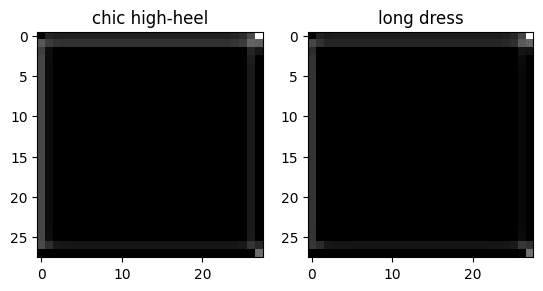

In [139]:
import matplotlib.pyplot as plt

img1 = sample("chic high-heel", model, text_encoder)
img2 = sample("long dress", model, text_encoder)

# compare visually
plt.subplot(1, 2, 1)
plt.imshow((img1.squeeze().cpu().clamp(-1, 1) + 1) / 2, cmap='gray') # Rescales from [-1, 1] → [0, 1] so plt.imshow() displays it properly.
plt.title("chic high-heel")

plt.subplot(1, 2, 2)
plt.imshow((img2.squeeze().cpu().clamp(-1, 1) + 1) / 2, cmap='gray')
plt.title("long dress")



